## Higgs Effective Field Theory (HEFT) Study: Prepare Training Data
> Created: Feb 15, 2024 Nicola de Filippis<br>
> Updated: Feb 20, 2025 HBP protect against both negative and zero cross sections<br>

### Introduction

In this project, the physics model of interest is the Higgs effective field theory (HEFT), defined by a 5D parameter space of Wilson coefficients [1]:
\begin{align}
    \theta & = c_{hhh}, c_t, c_{tt}, c_{ggh}, c_{gghh}.
\end{align}
For this investigation, we restrict our attention to a single observable, namely, the di-Higgs mass denoted by $m_{hh}$. The Standard Model (SM) values for these parameters are $c_{hhh} = c_t = 1$, and $c_{tt} = c_{ggh} = c_{gghh} = 0$. In general, we would consider multiple observables simultaneously.

We shall use simulation-based inference to construct **confidence sets**, at confidence level (CL) $\tau$, in the HEFT and later SMEFT parameter spaces. This requires approximating $\mathbb{P}(\lambda \le \lambda_0 | \theta) = \mathbb{E}(Z | \theta)$ [2,3], which we shall do in two different ways: 1) using a multi-dimensional histogram constructed using a kdtree and 2) a machine learning (ML) model, where for a given hypothesis $H_0: \theta = \theta_0$ versus $H_1: \theta \ne \theta_0$, $\lambda_0$ is the observed value of a test statistic $\lambda$ with the property that large values of the test statistic *disfavor* the hypothesis $H_0$. 

Given the cumulative distribution function (cdf), $\mathbb{P}(\lambda \le \lambda_0 | \theta)$, a confidence set at CL $\tau$ is the set of $\theta$ values for which $\mathbb{P}(\lambda \le \lambda_0 | \theta) \leq \tau$.  By definition, a confidence set (in the simplest case in which we restrict ourselves to a single class of experiments) is an observation-dependent set of $\theta$ values which upon repeated replication of the experiment is guaranteed to include the true value of $\theta$ a fraction $\ge \tau$.


### Training data
In principle [2,3], to approximate $\mathbb{P}(\lambda \le \lambda_0 | \theta)$ we need to sample the HEFT parameter space sufficiently densely and, at every point, simulate data like the ones actually observed. However, if it is computationally infeasible to sample the parameter space densely enough, the next option is to use a sparser sampling of the parameter space and reweight existing simulated data to mimic the sampling of data at any other point $\theta$. To do this requires knowledge of the cross section per binned observables, or the differential cross section,  as a function of both the *observables* and the *parameters*; here, $m_{hh}$ and $\theta$, respectively. Therefore, one sub-goal of the project is construct a parametrization of this function.

This notebook prepares the data needed to train a model of the di-Higgs cross section as a function of $m_{hh}$ and the Wilson coefficients, $\theta$.

### References
  1. Lina Alasfar *et al.*, arXiv:2304.01968v1
  2. Ann Lee *et al.*, https://arxiv.org/abs/2107.03920
  3. Ali Al Kadhim *et al.*, https://iopscience.iop.org/article/10.1088/2632-2153/ad218e


In [1]:
import os, sys

# the standard module for tabular data
import pandas as pd

# the standard module for array manipulation
import numpy as np

# the standard modules for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# update fonts
FONTSIZE = 16
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)

### Load $\texttt{POWHEG}$ data

Note 1: $\kappa_\lambda \equiv c_{hhh}$.

Note 2: The bin widths in $m_{hh}$ is 15 GeV.

In [5]:
def read_data(datafiles):
    df = []
    for datafile in datafiles:
        print('reading %s' % datafile)
        df.append( pd.read_csv(datafile) )

    # concatenate dataframes
    df = pd.concat(df)
    
    # make number of rows a multiple of 20
    total  = len(df)
    total  = int(total / 20)
    total  = 20 * total
    
    print('\nnumber of rows read: %d\n' % len(df))

    # randomly shuffle order of rows in dataframe
    df = df.sample(frac=1).reset_index(drop=True)
    return df

In [7]:
!ls ../data

heft_gauss_spectra.csv
heft_gauss_traindata.csv
heft_traindata.csv
powheg_total_13TeV_SMbig_klambda_1_ct_1_ctt_0_cggh_0_cgghh_0_oldStyle.csv
powheg_total_gauss_params.csv


In [8]:
datafiles = ['../data/powheg_total_gauss_params.csv']

dfBP = read_data(datafiles)
dfBP[:5]

reading ../data/powheg_total_gauss_params.csv

number of rows read: 1000



,klambda,CT,CTT,CGHH,CGGHH,0,1,2,3,4,...,92,93,94,95,96,97,98,99,100,101
0,2.711703,-1.386509,-2.294897,1.364440,-2.985932,0,0,0,0,0,...,0.007224,0.005949,0.009349,0.005524,0.004249,0.008499,0.005524,0.006799,0.005099,0.144906
1,1.085161,0.655006,0.682457,0.242556,-2.991125,0,0,0,0,0,...,0.005628,0.008150,0.004948,0.006792,0.005045,0.006986,0.005725,0.005628,0.006404,0.157380
2,2.804336,-0.220474,-0.061718,0.136088,-2.831687,0,0,0,0,0,...,0.006662,0.005552,0.005058,0.005675,0.006045,0.006045,0.004071,0.005799,0.004442,0.135468
3,1.652181,0.942134,1.060699,-0.682451,-1.062963,0,0,0,0,0,...,0.001032,0.000897,0.001086,0.001032,0.000745,0.000870,0.000844,0.000835,0.000826,0.022326
4,2.038406,0.157461,2.912844,0.452766,-1.184312,0,0,0,0,0,...,0.001846,0.001699,0.001625,0.001551,0.000960,0.002585,0.002216,0.000960,0.000812,0.041654


### Convert to $\texttt{numpy}$ arrays
 1. Get Wilson coefficients and cross sections / bin
 2. Protect against negative cross sections
 3. Pick cross sections from bin 17 (first non-zero bin) to 96

In [9]:
def get_column_names(df, first='17', last='96'):
    # get column names
    columns = list(df.columns)
    params  = columns[0:5]
    
    firstbin= columns.index(first)
    lastbin = columns.index(last)
    
    bins = columns[firstbin:lastbin+1]
    return params, bins

params, bins = get_column_names(dfBP)

params, bins[0], bins[-1], len(bins)

(['klambda', 'CT', 'CTT', 'CGHH', 'CGGHH'], '17', '96', 80)

In [10]:
# get Wilson coefficients
wilson = dfBP[params].to_numpy()
print(wilson.shape)

# get cross section data
BP = dfBP[bins].to_numpy()
print(BP.shape)

print(f'cross section/bin (min, mean, max, std): '\
      f'{BP.min():8.3e} pb, {BP.mean():8.3e} pb, {BP.max():8.3e} pb, {BP.std():8.3e} pb')

BP.shape, BP[0]

(1000, 5)
(1000, 80)
cross section/bin (min, mean, max, std): 0.000e+00 pb, 9.128e-02 pb, 2.042e+01 pb, 4.022e-01 pb


((1000, 80),
 array([0.04036977, 0.2230961 , 0.30935994, 0.34802991, 0.36120322,
        0.42239529, 0.4415178 , 0.50908405, 0.53373086, 0.53245604,
        0.53203106, 0.47848803, 0.43174407, 0.40539748, 0.38457519,
        0.35015464, 0.32465795, 0.28556302, 0.23754422, 0.22607072,
        0.21332237, 0.18825062, 0.17295259, 0.1436314 , 0.13768217,
        0.13215788, 0.12535876, 0.11218547, 0.1011369 , 0.09476273,
        0.08286427, 0.07266559, 0.06671636, 0.06374174, 0.06246691,
        0.05014351, 0.05099339, 0.04121966, 0.04334439, 0.03739516,
        0.03994483, 0.03951988, 0.03442054, 0.0339956 , 0.02507175,
        0.03017109, 0.02634659, 0.02507175, 0.02252208, 0.01827263,
        0.02719648, 0.01997241, 0.02209714, 0.01784769, 0.01487307,
        0.0169978 , 0.01487307, 0.01487307, 0.01274835, 0.01359824,
        0.0123234 , 0.01274835, 0.00977373, 0.01444813, 0.01657285,
        0.0084989 , 0.01487307, 0.00764901, 0.00977373, 0.01019868,
        0.00807395, 0.00764901, 0.0

### Save spectra

In [11]:
# first place data in a dictionary
dmap = {'klambda': wilson.T[0],
        'CT': wilson.T[1],
        'CTT': wilson.T[2], 
        'CGGH': wilson.T[3], 
        'CGGHH': wilson.T[4]}

dmap.update( {key: BP.T[i] for i, key in enumerate(bins)} )

# then save to a csv file
df = pd.DataFrame(dmap)
df.to_csv('../data/heft_gauss_spectra.csv', index=False)

len(df), df[:5]

(1000,
     klambda        CT       CTT      CGGH     CGGHH        17        18  \
 0  2.711703 -1.386509 -2.294897  1.364440 -2.985932  0.040370  0.223096   
 1  1.085161  0.655006  0.682457  0.242556 -2.991125  0.005725  0.040655   
 2  2.804336 -0.220474 -0.061718  0.136088 -2.831687  0.010117  0.063046   
 3  1.652181  0.942134  1.060699 -0.682451 -1.062963  0.000359  0.001875   
 4  2.038406  0.157461  2.912844  0.452766 -1.184312  0.003028  0.021639   
 
          19        20        21  ...        87        88        89        90  \
 0  0.309360  0.348030  0.361203  ...  0.008074  0.007649  0.007224  0.007224   
 1  0.054627  0.054724  0.058605  ...  0.009121  0.007471  0.006501  0.008053   
 2  0.091669  0.096358  0.099812  ...  0.006539  0.008020  0.005922  0.007032   
 3  0.002539  0.002342  0.002351  ...  0.001122  0.001265  0.001041  0.001032   
 4  0.030059  0.035967  0.036706  ...  0.002068  0.002733  0.001994  0.002216   
 
          91        92        93        94     

### Save shuffled training data to a csv file

Format: $k_{lambda}$, $c_{t}$,$c_{tt}$, $c_{ggh}$, $c_{ggh}$, $m_{hh}$, $\sigma$

Save data from the last 300 spectra and keep the first 40 spectra to test the spectrum model.

In [12]:
# compute mid-points of di-Higgs mass bins, with the mass range mapped to the
# unit interval
_, xbins = BP.shape
xmin = 0
xmax = xbins/100 # bin width is 0.01, which corresponds to 15 GeV

x = np.linspace(xmin, xmax, xbins+1)
# x[1:] = x[1], x[2] ...,x[n-1]
# x[:-1]= x[0], x[1],...,x[n-2]
x = (x[1:]+x[:-1])/2

# fill list with training data 
START = 40
data  = []
for params, spectrum in zip(wilson[START:], BP[START:]):
    p = list(params)

    # increase the incidence of spectra with 
    # cross sections < 0.5 pb
    total_xsec = spectrum.sum()
    if total_xsec < 0.5:
        N = 1
    else:
        N = 1
        
    d = []
    for _ in range(N):
        for mhh, sigma in zip(x, spectrum):
            d = p + [mhh, sigma] # klambda, CT, CTT, CGGH, CGGHH, MHH, SIGMA
            data.append(d)

# keep xsec > 0
data = np.array(data)
select = data.T[6] > 0 # keep xsec > 0
data = data[select]

# randomly shuffle rows
np.random.shuffle(data)

N = len(data) // 1000
N *= 1000
data = data[:N]
print(f'training data size: {len(data):5d}')

# create dataframe
data = data.T  # transpose to shape (5, N)
df = pd.DataFrame({'klambda':   data[0],
                   'CT':    data[1],
                   'CTT':   data[2], 
                   'CGGH':  data[3], 
                   'CGGHH': data[4], 
                   'mhh':   data[5], 
                   'sigma': data[6]})

# save training data to a csv file
df.to_csv('../data/heft_gauss_traindata.csv', index=False)

df

training data size: 76000


,klambda,CT,CTT,CGGH,CGGHH,mhh,sigma
0,0.295029,1.523535,4.595587,-0.644952,-3.502800,0.405,0.040269
1,0.288836,4.343446,0.975331,-3.621343,0.963441,0.765,0.001861
2,-0.126649,-0.749105,-2.904325,1.460002,2.766894,0.375,0.028461
3,1.675572,1.903516,4.345243,2.766182,1.382319,0.615,0.009330
4,1.457758,2.493618,-3.030521,-1.400071,2.889318,0.575,0.016586
...,...,...,...,...,...,...,...
75995,1.980596,-4.015936,1.982755,0.124658,0.163734,0.395,0.014257
75996,1.468120,3.869886,0.556228,1.934090,-1.450837,0.575,0.003055
75997,0.189696,-1.048925,-2.814375,3.722303,-0.036630,0.005,0.005588
75998,2.284315,1.851641,0.422874,3.434916,-1.802641,0.005,0.006597


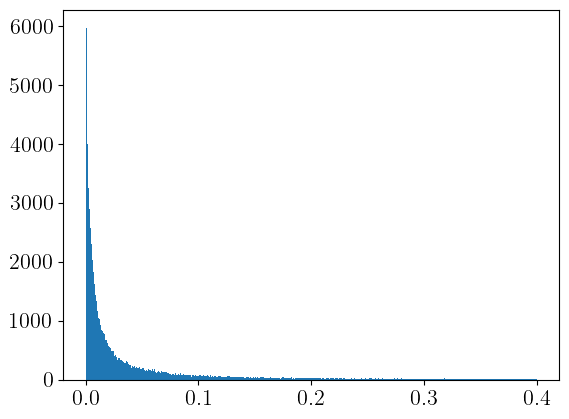

In [13]:
plt.hist(df.sigma, bins=500, range=(0, 0.4));